# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression

# Read and preprocess data

## Read data

In [2]:
lldf = pd.read_csv('lovelive.csv')
bddf = pd.read_csv('bandori.csv')

## Convert and sort datetime columns

In [3]:
lldf['publishedAt'] = pd.to_datetime(lldf['publishedAt'], infer_datetime_format=True)  
bddf['publishedAt'] = pd.to_datetime(bddf['publishedAt'], infer_datetime_format=True)

lldf.sort_values('publishedAt', inplace=True)
bddf.sort_values('publishedAt', inplace=True)
lldf.reset_index(inplace=True, drop=True)
bddf.reset_index(inplace=True, drop=True)  

## Reformat datetime into `'YYYY-MM'`

In [4]:
lldf['monthYear'] = lldf['publishedAt'].apply(lambda x: x.year).astype(str) \
    + '-' + lldf['publishedAt'].apply(lambda x: x.month).astype(str)

In [5]:
bddf['monthYear'] = bddf['publishedAt'].apply(lambda x: x.year).astype(str) \
    + '-' + bddf['publishedAt'].apply(lambda x: x.month).astype(str)

In [6]:
bdCumsum = bddf.groupby(by='monthYear').sum('viewsCount').cumsum()
llCumsum = lldf.groupby(by='monthYear').sum('viewsCount').cumsum()

# Plotting

## Line plot for cumsum
### Merge 2 dataframes

In [7]:
mergedDf = pd.concat([bdCumsum, llCumsum], axis=1).fillna(0).sort_index()
mergedDf.columns = ['bandori', 'lovelive']
mergedDf.head()

,bandori,lovelive
monthYear,,
2011-12,0.0,55979
2011-4,0.0,358166
2011-5,0.0,626245
2011-6,0.0,989457
2011-7,0.0,3601290


### Plot

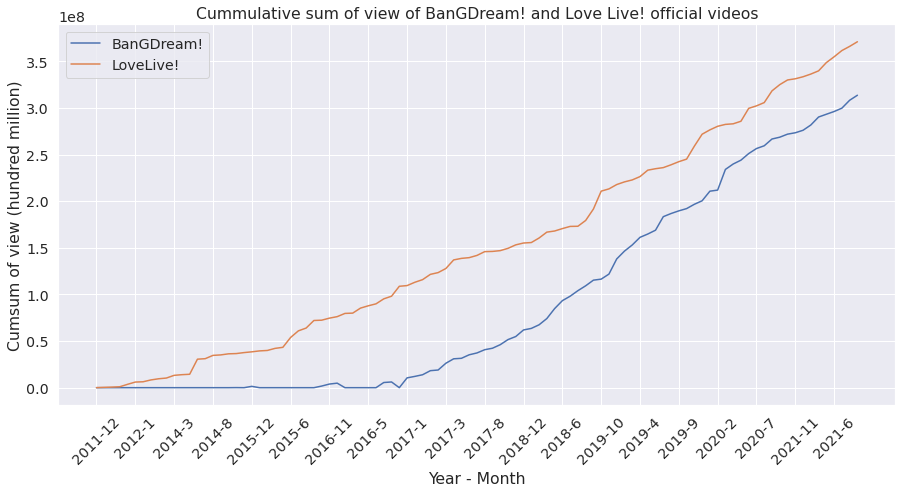

In [8]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)
sns.lineplot(data=mergedDf, x=mergedDf.index, y='bandori')
sns.lineplot(data=mergedDf, x=mergedDf.index, y='lovelive')

fig: plt.Figure = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(7)
plt.xticks(rotation=45)
ax: plt.Axes = plt.gca()
    
ax.set_xticks(np.arange(0, len(mergedDf), 5));
ax.legend(['BanGDream!', 'LoveLive!'])
ax.set_ylabel('Cumsum of view (hundred million)')
ax.set_xlabel('Year - Month')
ax.set_title('Cummulative sum of view of BanGDream! and Love Live! official videos');

In [9]:
fig.savefig('stats.png', dpi=150)

## Building linear model for cumsum

### Create index map (map datetime string to int)

In [10]:
dtToInt = {dt: i for i, dt in enumerate(mergedDf.index)}
intToDt = {i: dt for dt, i in dtToInt.items()}

### Add additional int-based time column to cumsum dataframes

In [11]:
bdCumsum['intTime'] = bdCumsum.index.to_series().apply(lambda i: dtToInt[i])
llCumsum['intTime'] = llCumsum.index.to_series().apply(lambda i: dtToInt[i])

### Create linear models

In [12]:
bdLm = LinearRegression()
bdLm.fit(bdCumsum[['intTime']], bdCumsum[['viewCount']])

llLm = LinearRegression()
llLm.fit(llCumsum[['intTime']], llCumsum[['viewCount']])

LinearRegression()

### Predict until the next 2025

#### Make a "future mapper" to map future dates with their int-based indices

In [13]:
def makeFutureDateMapper(lastMonth, lastYear, lastMapper, endYear):
    year = lastYear
    month = lastMonth + 1
    mapper = lastMapper + 1
    
    resultMapper = dict()
    while year <= endYear:
        if month > 12:
            year += 1
            month = 1
            
        resultMapper[mapper] = '%d-%d' % (year, month)
        mapper += 1
        month += 1
        
    return resultMapper

In [14]:
lastMapper = list(intToDt.keys()).index(max(intToDt.keys()))
lastDate = intToDt[lastMapper].split('-')
lastYear, lastMonth = lastDate

In [15]:
DEST_YEAR = 2030
futureMapper = makeFutureDateMapper(int(lastMonth), int(lastYear), lastMapper, DEST_YEAR)

In [16]:
intToDt.update(futureMapper)

### Make predictions

In [17]:
xrange = np.array(list(intToDt.keys()))

In [18]:
bdPred = bdLm.predict(xrange.reshape(-1, 1)).ravel()
llPred = llLm.predict(xrange.reshape(-1, 1)).ravel()

### Draw plot

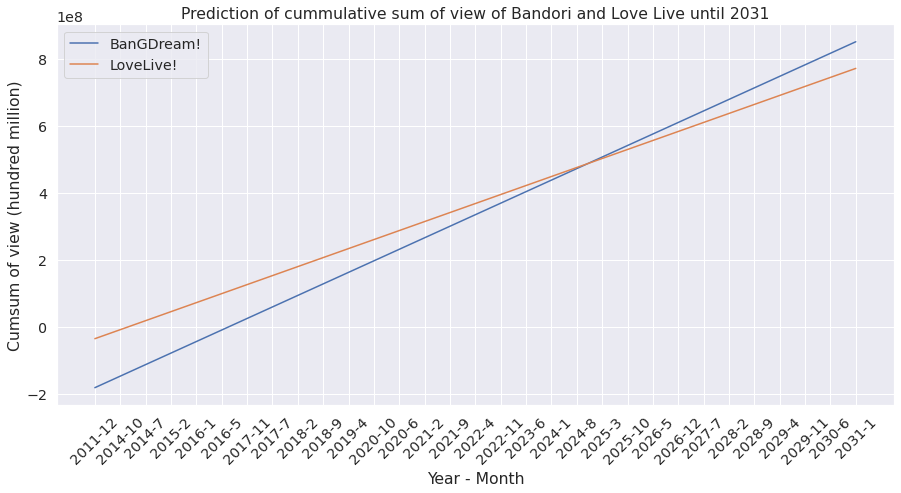

In [21]:
sns.lineplot(x=xrange, y=bdPred)
sns.lineplot(x=xrange, y=llPred)

fig: plt.Figure = plt.gcf()
ax: plt.Axes = plt.gca()

xticks = np.arange(0, len(intToDt), 7)
ax.set_xticks(xticks)
ax.set_xticklabels([intToDt[i] for i in xticks])
fig.set_figwidth(15)
fig.set_figheight(7)
plt.xticks(rotation=45)
plt.legend(['BanGDream!', 'LoveLive!'])

ax.set_ylabel('Cumsum of view (hundred million)')
ax.set_xlabel('Year - Month')
ax.set_title('Prediction of cummulative sum of view of Bandori and Love Live until 2031');

In [22]:
fig.savefig('pred.png', dpi=150)